In [2]:
import xarray as xr

In [5]:
ds = xr.open_dataset("/glade/u/home/noraloose/ucla-roms/Examples/CDR/cdr_release.nc")

In [6]:
ds

<xarray.Dataset> Size: 808B
Dimensions:     (ncdr: 1, time: 12, ntracers: 3)
Dimensions without coordinates: ncdr, time, ntracers
Data variables:
    cdr_lon     (ncdr) float64 8B ...
    cdr_lat     (ncdr) float64 8B ...
    cdr_hsc     (ncdr) float64 8B ...
    cdr_vsc     (ncdr) float64 8B ...
    cdr_dep     (ncdr) float64 8B ...
    cdr_time    (time) float64 96B ...
    cdr_volume  (time, ncdr) float64 96B ...
    cdr_tracer  (time, ntracers, ncdr) float64 288B ...
    cdr_trcflx  (time, ntracers, ncdr) float64 288B ...

In [5]:
ds.cdr_lon.values

array([-120.718])

In [6]:
ds.cdr_lat.values

array([34.56])

In [7]:
ds.cdr_hsc.values

array([5000.])

In [8]:
ds.cdr_vsc.values

array([10.])

In [27]:
ds.cdr_dep.values

array([20.])

In [9]:
ds.cdr_time.values

array([ 15.,  45.,  75., 105., 135., 165., 195., 225., 255., 285., 315.,
       345.])

In [14]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Volume flux (m3/s)')

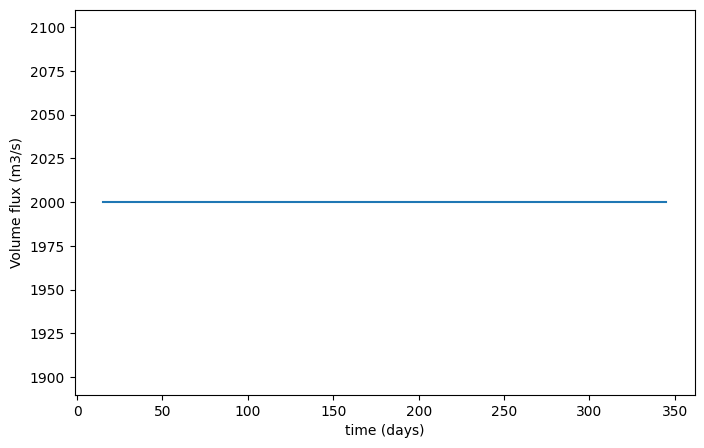

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(ds.cdr_time.values, ds.cdr_volume.values)
ax.set_xlabel("time (days)")
ax.set_ylabel("Volume flux (m3/s)")

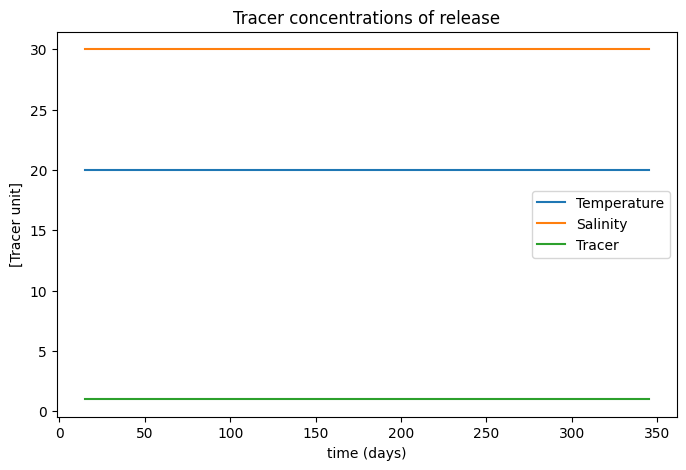

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(ds.cdr_time.values, ds.cdr_tracer.isel(ntracers=0).values, label="Temperature")
ax.plot(ds.cdr_time.values, ds.cdr_tracer.isel(ntracers=1).values, label="Salinity")
ax.plot(ds.cdr_time.values, ds.cdr_tracer.isel(ntracers=2).values, label="Tracer")
ax.set_xlabel("time (days)")
ax.set_ylabel("[Tracer unit]")
ax.set_title("Tracer concentrations of release")
ax.legend()

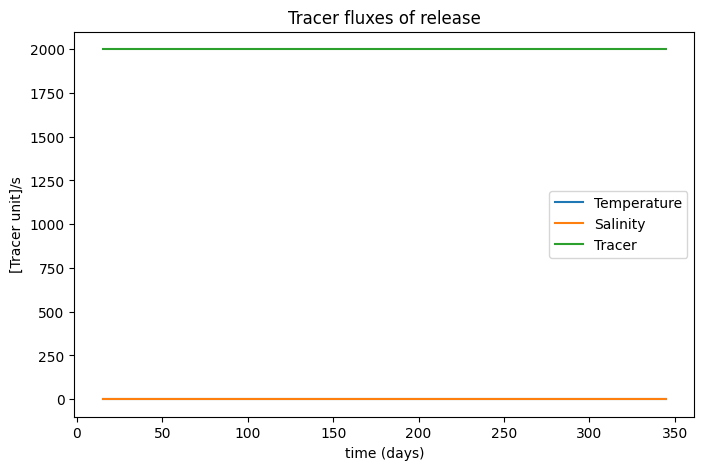

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(ds.cdr_time.values, ds.cdr_trcflx.isel(ntracers=0).values, label="Temperature")
ax.plot(ds.cdr_time.values, ds.cdr_trcflx.isel(ntracers=1).values, label="Salinity")
ax.plot(ds.cdr_time.values, ds.cdr_trcflx.isel(ntracers=2).values, label="Tracer")
ax.set_xlabel("time (days)")
ax.set_ylabel("[Tracer unit]/s")
ax.set_title("Tracer fluxes of release")
ax.legend()

In [36]:
ds.cdr_trcflx.isel(ntracers=0).values

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [37]:
ds.cdr_trcflx.isel(ntracers=1).values

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [57]:
from dataclasses import dataclass, field
from typing import Dict, Union, List, Optional
from datetime import datetime

In [248]:
@dataclass(kw_only=True)
class CDRPipeForcing:
    """Represents CDR pipe forcing data for ROMS, supporting both constant and time-varying tracers and volumes.

    Parameters
    ----------
    grid : Grid, optional
        Object representing the grid information for spatial distribution.
    start_time : datetime
        Start time of the model simulation.
    end_time : datetime
        End time of the model simulation.
    model_reference_date : datetime, optional
        Reference date for the model. Default is January 1, 2000.

    Attributes
    ----------
    ds : xr.Dataset
        The xarray Dataset containing the CDR pipe forcing data, which includes tracers, volumes, and associated time information.
    """

    grid: Optional['Grid'] = None
    start_time : datetime
    end_time : datetime
    model_reference_date: datetime = datetime(2000, 1, 1)

    def __post_init__(self):

        if self.start_time >= self.end_time:
            raise ValueError("start_time must be before end_time.")

        self.ds = xr.Dataset(
            {
                "cdr_time": (["time"], np.empty(0)),  # Empty time dimension initially
                "cdr_volume": (["time"], np.empty(0)),  # Empty time dimension initially
                "cdr_tracer": (["time", "ncdr",], np.empty(0, 0)),  # Empty time dimension initially

            },
            coords={
                "experiment_name": (["ncdr"], np.empty(0, dtype=str)),  # Empty initially
            }   
        )
        self._add_global_metadata()
        
    def _add_global_metadata(self):
        
        self.ds = self.ds.assign_coords(
                {
                "tracer_name": (["ntracers"], [
                    "temp", "salt", "PO4", "NO3", "SiO3", "NH4", "Fe", "Lig", "O2",
                    "DIC", "DIC_ALT_CO2", "ALK", "ALK_ALT_CO2", "DOC", "DON", "DOP",
                    "DOPr", "DONr", "DOCr", "zooC", "spChl", "spC", "spP", "spFe",
                    "spCaCO3", "diatChl", "diatC", "diatP", "diatFe", "diatSi", "diazChl",
                    "diazC", "diazP", "diazFe"
                ])
            }
        )

    def add_release(
        self,
        *,
        name: str,
        lat: float,
        lon: float,
        depth: float,
        release_start_time: Optional[datetime] = None,
        release_end_time: Optional[datetime] = None,
        times: Optional[List[datetime]] = None,  # Can be None for constant tracers
        fill_values: Optional[str] = "auto_fill",  # Default to "auto_fill" for missing tracer data
        tracers: Optional[Dict[str, Union[float, List[float]]]] = None,
        volume: Union[float, List[float]] = 0.0,  # Default volume to 0.0 if not provided
    ):
        """
        Parameters
        ----------
        name : str
            Name of the release experiment.
        lat : float
            Latitude of the CDR release. Must be between -90 and 90.
        lon : float
            Longitude of the CDR release. No restrictions on bounds; longitude can be any value.
        depth : float
            Depth of the CDR release.
        release_start_time : datetime, optional
            Start time of the CDR release. Required if `times` is `None`.
        release_end_time : datetime, optional
            End time of the CDR release. Required if `times` is `None`.
        times : List[datetime], optional
            List of times for time-varying tracers. Required if `release_start_time` and `release_end_time` are not provided.
        tracers : dict
            A dictionary of tracer names and their corresponding values, which can be constant or time-varying. 
            Example formats:
            - Constant tracers: {"temp": 20.0, "salt": 1.0, "ALK": 2000.0}
            - Time-varying tracers: {"temp": [19.5, 20, 20, 20], "salt": [1.1, 2, 1, 1], "ALK": [2000.0, 2014.3, 2001.0, 2004.2]} (with `times` set to four corresponding datetime entries)
        fill_values : Optional[str], default="auto_fill"
            Defines how missing tracer data should be handled:
            - "auto_fill": Use the model's default fill behavior.
            - "zero_fill": Fill missing values with zeros.
        volume : Union[float, List[float]], optional
            Volume of the CDR release, either constant (single float) or a time series (list of floats).
        """


        if release_start_time and release_end_time and not times:
            # Use start and end times for constant tracers if no `times` provided
            times = [release_start_time, release_end_time]
        elif times and not (release_start_time and release_end_time):
            # Time-varying tracers: derive start and end time from `times`
            release_start_time, release_end_time = times[0], times[-1]
        else:
            raise ValueError("Either `times` must be provided, or both `release_start_time` and `release_end_time` must be specified.")

        times = np.array(times)
        times = (
            (times - self.model_reference_date).astype("timedelta64[ns]")
            / np.timedelta64(1, "D")  # Convert to days
        )
            
        # union with existing times
        if len(self.ds["cdr_time"]) > 0:
            existing_times = self.ds["cdr_time"].values
            union_time = np.union1d(existing_times, times)
        else:
            union_time = np.array(times)

        # overwrite dataset because length of time dimension might change
        ds = xr.Dataset()
        ds["cdr_time"] = ("time", union_time)
        
        # deal with updating previous release experiment data
        if len(self.ds["ncdr"]) > 0:
            new_volume = np.interp(
                    union_time.astype(np.float64),
                    np.array(self.ds["time"]).astype(np.float64),
                    self.ds["cdr_volume"]
                    )
            
            ds["cdr_volume"] = ("time", new_volume)
        else:
            ds["cdr_volume"] = xr.zeros_like(self.ds.ncdr * 
            
        print(ds)
        
        # append the experiment
        new_experiment_name = np.concatenate([self.ds.experiment_name.values, [name]])
        ds = ds.update(
            {"experiment_name": (["ncdr"], new_experiment_name)}
        )
        print(ds)
        if isinstance(volume, list):
            new_volume = np.interp(
                    union_time.astype(np.float64),
                    np.array(times).astype(np.float64),
                    volume
                )
        else:
            new_volume = np.full(len(union_time), volume)
            print(new_volume)

        ds["cdr_volume"].loc[{"experiment_name": name}] = new_volume


In [249]:
from roms_tools import Grid

In [250]:
grid = Grid(
    nx=100,  # number of grid points in x-direction
    ny=100,  # number of grid points in y-direction
    size_x=2500,  # domain size in x-direction (in km)
    size_y=2500,  # domain size in y-direction (in km)
    center_lon=-15,  # longitude of the center of the domain
    center_lat=65,  # latitude of the center of the domain
    rot=-30,  # rotation of the grid (in degrees)
    N=100,  # number of vertical layers
)

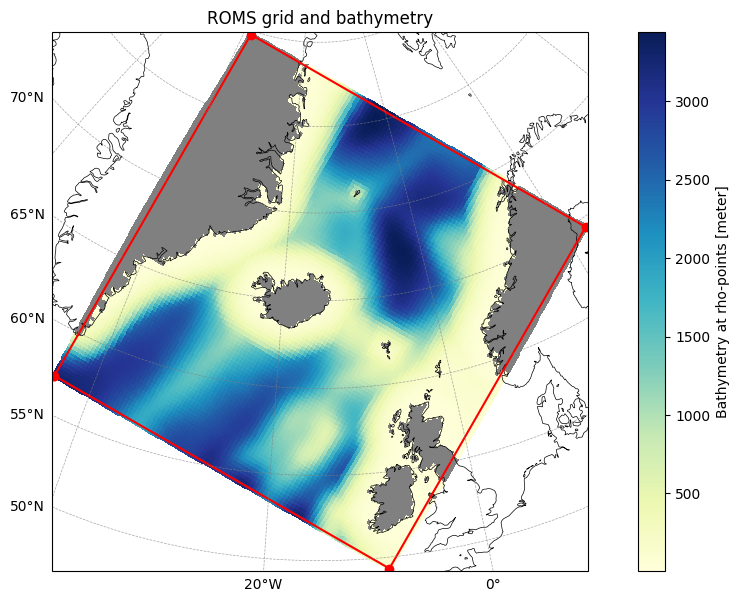

In [251]:
grid.plot()

In [252]:
cdr_forcing = CDRPipeForcing(
    grid=grid,
    start_time=datetime(2010, 1, 1),
    end_time=datetime(2012, 1, 1)
)
    

In [253]:
cdr_forcing.ds

<xarray.Dataset> Size: 1kB
Dimensions:          (time: 0, ncdr: 0, ntracers: 34)
Coordinates:
    experiment_name  (ncdr) <U1 0B 
    tracer_name      (ntracers) <U11 1kB 'temp' 'salt' ... 'diazP' 'diazFe'
Dimensions without coordinates: time, ncdr, ntracers
Data variables:
    cdr_time         (time) float64 0B 
    cdr_volume       (time) float64 0B 
    cdr_tracer       (time) float64 0B

In [254]:
cdr_forcing.add_release(
    name="Iceland",
    lat=65,
    lon=-25,
    depth=10,
    release_start_time=datetime(2010, 1, 15),
    release_end_time=datetime(2010, 1, 30),
    volume=1000
)

/glade/derecho/scratch/noraloose/tmp/ipykernel_79334/4009298416.py:127: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = self.ds.drop("time")


ValueError: These variables cannot be found in this dataset: ['time']

In [95]:
cdr_forcing.ds

<xarray.Dataset> Size: 2kB
Dimensions:          (time: 0, ntracers: 34, ncdr: 1)
Coordinates:
    tracer_name      (ntracers) <U11 1kB 'temp' 'salt' ... 'diazP' 'diazFe'
    experiment_name  (ncdr) <U7 28B 'Iceland'
Dimensions without coordinates: time, ntracers, ncdr
Data variables:
    cdr_time         (time) float64 0B

In [ ]:
from datetime import datetime
from typing import Dict, List, Optional, Union

class CDRPipeForcing:
    """Represents CDR pipe forcing data for ROMS, supporting both constant and time-varying tracers and volumes.

    Parameters
    ----------
    grid : Grid, optional
        Object representing the grid information for spatial distribution.
    start_time : datetime
        Start time of the model simulation.
    end_time : datetime
        End time of the model simulation.
    model_reference_date : datetime, optional
        Reference date for the model. Default is January 1, 2000.

    Attributes
    ----------
    ds : xr.Dataset
        The xarray Dataset containing the CDR pipe forcing data, which includes tracers, volumes, and associated time information.
    """
    
    grid: Optional['Grid'] = None
    start_time : datetime
    end_time : datetime
    model_reference_date: datetime = datetime(2000, 1, 1)

    def __post_init__(self):

        if self.start_time >= self.end_time:
            raise ValueError("start_time must be before end_time.")
                
        self.ds = xr.Dataset()
        
        self.ds["tracer_name"] = xr.DataArray(
                [
                    "temp",
                    "salt",
                    "PO4",
                    "NO3",
                    "SiO3",
                    "NH4",
                    "Fe",
                    "Lig",
                    "O2",
                    "DIC",
                    "DIC_ALT_CO2",
                    "ALK",
                    "ALK_ALT_CO2",
                    "DOC",
                    "DON",
                    "DOP",
                    "DOPr",
                    "DONr",
                    "DOCr",
                    "zooC",
                    "spChl",
                    "spC",
                    "spP",
                    "spFe",
                    "spCaCO3",
                    "diatChl",
                    "diatC",
                    "diatP",
                    "diatFe",
                    "diatSi",
                    "diazChl",
                    "diazC",
                    "diazP",
                    "diazFe",
                ],
                dims="ntracers",
            attrs={"long_name": "Tracer name"}
        )

    self.number_of_releases = 0
        
    def add_release(
        self,
        name: str,
        lat: float,
        lon: float,
        depth: float,
        release_start_time: Optional[datetime] = None,
        release_end_time: Optional[datetime] = None,
        times: Optional[List[datetime]] = None,  # Can be None for constant tracers
        fill_values: Optional[str] = "auto_fill",  # Default to "auto_fill" for missing tracer data
        tracers: Dict[str, Union[float, List[float]]],
        volume: Union[float, List[float]] = 0.0,  # Default volume to 0.0 if not provided
    ):
        """
        Parameters
        ----------
        name : str
            Name of the release experiment.
        lat : float
            Latitude of the CDR release. Must be between -90 and 90.
        lon : float
            Longitude of the CDR release. No restrictions on bounds; longitude can be any value.
        depth : float
            Depth of the CDR release.
        release_start_time : datetime, optional
            Start time of the CDR release. Required if `times` is `None`.
        release_end_time : datetime, optional
            End time of the CDR release. Required if `times` is `None`.
        times : List[datetime], optional
            List of times for time-varying tracers. Required if `release_start_time` and `release_end_time` are not provided.
        tracers : dict
            A dictionary of tracer names and their corresponding values, which can be constant or time-varying. 
            Example formats:
            - Constant tracers: {"temp": 20.0, "salt": 1.0, "ALK": 2000.0}
            - Time-varying tracers: {"temp": [19.5, 20, 20, 20], "salt": [1.1, 2, 1, 1], "ALK": [2000.0, 2014.3, 2001.0, 2004.2]} (with `times` set to four corresponding datetime entries)
        fill_values : Optional[str], default="auto_fill"
            Defines how missing tracer data should be handled:
            - "auto_fill": Use the model's default fill behavior.
            - "zero_fill": Fill missing values with zeros.
        volume : Union[float, List[float]], optional
            Volume of the CDR release, either constant (single float) or a time series (list of floats).
        """

        self._input_checks(name, lat, lon, depth, release_start_time, release_end_time, times, tracers, volume, fill_values)
        self.number_of_releases += 1

        # Determine time dimension
        # Check if 
        if release_start_time and release_end_time and not times:
            # Use start and end times for constant tracers if no `times` provided
            times = [release_start_time, release_end_time]
        elif times and not (release_start_time and release_end_time):
            # Time-varying tracers: derive start and end time from `times`
            release_start_time, release_end_time = times[0], times[-1]
        else:
            raise ValueError("Either `times` must be provided, or both `release_start_time` and `release_end_time` must be specified.")

        # Prepare time coordinate
        time_coord = np.array([np.datetime64(t) for t in times])

        # Interpolate volume and tracers to union of existing and new times
        if "time" in self.ds.coords:
            existing_time = self.ds["time"].values
            union_time = np.union1d(existing_time, time_coord)
        else:
            union_time = time_coord

        # Prepare tracer and volume data
        tracer_data = {}
        for tracer, values in tracers.items():
            if isinstance(values, list):
                if len(values) != len(times):
                    raise ValueError(f"Length of time-varying tracer '{tracer}' does not match length of `times`.")
                tracer_data[tracer] = np.array(values)
            else:
                tracer_data[tracer] = np.full(len(times), values)

        # Handle volume data
        if isinstance(volume, list):
            if len(volume) != len(times):
                raise ValueError("Length of time-varying `volume` does not match length of `times`.")
            volume_data = np.array(volume)
        else:
            volume_data = np.full(len(times), volume)

        # Create a dataset for the new release
        release_ds = xr.Dataset(
            {
                f"{name}_volume": (["time"], volume_data),
                **{f"{name}_{tracer}": (["time"], data) for tracer, data in tracer_data.items()},
            },
            coords={"time": union_time},
        )

        # Merge the new release dataset with the existing dataset
        if self.ds:
            self.ds = xr.merge([self.ds, release_ds], combine_attrs="override")
        else:
            self.ds = release_ds

    

    def _input_checks(name, lat, lon, depth, release_start_time, release_end_time, times, tracers, volume, fill_values):
        # Check that lat is valid
        if not (-90 <= lat <= 90):
            raise ValueError("Latitude must be between -90 and 90.")

        # Check that depth is non-negative
        if depth < 0:
            raise ValueError("Depth must be a non-negative number.")

        # Check that release_start_time is before release_end_time
        if release_start_time and release_end_time:
            if self.release_start_time >= self.release_end_time:
                raise ValueError("release_start_time must be before release_end_time.")

        # Ensure that times is either None (for constant tracers) or a list of datetimes
        if self.times is not None and not all(isinstance(t, datetime) for t in self.times):
            raise ValueError("If 'times' is provided, all entries must be datetime objects.")

        # Ensure that tracers dictionary is not empty for time-varying forcing
        if self.times is not None and not self.tracers:
            raise ValueError("The 'tracers' dictionary cannot be empty when 'times' is provided.")
            raise ValueError("The 'tracers' dictionary cannot be empty.")

        # Check that volume is valid
        if isinstance(self.volume, float) and self.volume < 0:
            raise ValueError("Volume must be a non-negative number.")
        elif isinstance(self.volume, list) and not all(v >= 0 for v in self.volume):
            raise ValueError("All entries in 'volume' list must be non-negative numbers.")

    # Ensure that time series for 'times', 'volume', and tracers are all the same length
    if self.times is not None:
        num_times = len(self.times)
        
        # Check that volume is either a constant or has the same length as 'times'
        if isinstance(self.volume, list) and len(self.volume) != num_times:
            raise ValueError(f"The length of 'volume' ({len(self.volume)}) does not match the length of 'times' ({num_times}).")
        
        # Check that each time-varying tracer has the same length as 'times'
        for key, tracer_values in self.tracers.items():
            if isinstance(tracer_values, list) and len(tracer_values) != num_times:
                raise ValueError(f"The length of tracer '{key}' ({len(tracer_values)}) does not match the length of 'times' ({num_times}).")



In [ ]:
            
        river_volume = (
            data.ds[data.var_names["flux"]] * data.ds[data.var_names["ratio"]]
        ).astype(np.float32)
        river_volume.attrs["long_name"] = "River volume flux"
        river_volume.attrs["units"] = "m^3/s"
        river_volume = river_volume.rename(
            {data.dim_names["time"]: "river_time", data.dim_names["station"]: "nriver"}
        )
        name = data.ds[data.var_names["name"]].rename(
            {data.dim_names["station"]: "nriver"}
        )
        name.attrs["long_name"] = "River name"
        river_volume.coords["river_name"] = name

        ds["river_volume"] = river_volume

        nriver = xr.DataArray(np.arange(1, len(ds.nriver) + 1), dims="nriver")
        nriver.attrs["long_name"] = "River ID (1-based Fortran indexing)"
        ds = ds.assign_coords({"nriver": nriver})

        ntracers = 2 + 32

        tracer_data = np.zeros(
            (len(ds.river_time), ntracers, len(ds.nriver)), dtype=np.float32
        )
        tracer_data[:, 0, :] = 17.0
        tracer_data[:, 1, :] = 1.0
        tracer_data[:, 2:, :] = 0.0

        river_tracer = xr.DataArray(
            tracer_data, dims=("river_time", "ntracers", "nriver")
        )
        river_tracer.attrs["long_name"] = "River tracer data"

        ds["river_tracer"] = river_tracer

        ds, time = convert_to_roms_time(
            ds, self.model_reference_date, self.climatology, time_name="river_time"
        )

        ds = ds.assign_coords({"river_time": time})

        return ds    
        